------

**<h1 style="text-align:center">Homework 11</h1>**

<p style="text-align:center">杨泽洲 320180942011 </p>

## Beginning

In the homework, I use SVM and DecisionTree to draw the ROC curve, learing curve and validation curve.  
In the proccess of drawing learning curve, I used **k-fold** and **ShuffleSplit**.   
We can use validation curve to find the best parameter.  
In the end of homework, I directly use Nested-cross-validation to optimize parameter and compared the results with the painting above.   
Some code I have commented out, you can turn them back and try something new.  
And the real comments are ended with '.'.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm,tree,datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

#Import the iris data.
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [2]:
# Change the target to the bianry to draw the ROC curve conveniently.
y = label_binarize(y, classes=[0, 1, 2])
# Num_classes is the number of lables.
num_classes = y.shape[1]
# Because the dataset is too easy,if we want to see more difficult line, we can add noisy features to make the problem harder.
# random_state = np.random.RandomState(0)
# num_samples, num_features = X.shape
# X = np.c_[X, random_state.randn(num_samples, 200 * num_features)]

# Split training and test sets with 1:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=0)

# Learn to predict each class against the other.
# classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,random_state=random_state))
classifier = OneVsRestClassifier(tree.DecisionTreeClassifier())
# y_score = classifier.fit(X_train, y_train).decision_function(X_test)
y_score=classifier.fit(X_train,y_train).predict_proba(X_test)

In [3]:
# Compute ROC curve and ROC area for each class.
fpr = dict()# FPR = FP / (TN + FP)  false positive rate
tpr = dict()# TPR = TP / (TP + FN)  true positive rate
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i],thresholds  = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

## ROC Curve

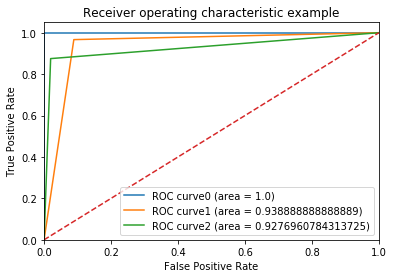

In [4]:
# Use the front data to draw the ROC curve.
plt.plot(fpr[0], tpr[0],label='ROC curve0 (area = {})'.format(roc_auc[0]))
plt.plot(fpr[1], tpr[1],label='ROC curve1 (area = {})'.format(roc_auc[1]))
plt.plot(fpr[2], tpr[2],label='ROC curve2 (area = {})'.format(roc_auc[2]))
plt.plot([0, 1], [0, 1],linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend()
plt.show()

In [5]:
# Compute micro-average ROC curve and ROC area.
# Micro-average and Macro-average are the flag of the multi-classification problem.

# Micro-average FPR = (FP1+FP2+FP3)/(TN1+TN2+TN3+FP1+FP2+FP3).
# Micro-average TPR = (TP1+TP2+TP3)/(TP1+TP2+TP3+FN1+FN2+FN3).
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(),y_score.ravel())
# Compute micro-average ROC curve and ROC area.
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates.
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points.
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC.
mean_tpr /= num_classes

# Macro-average FPR = (FPR1+FPR2+FPR3)/3.
# Macro-average TPR = (TPR1+TPR2+TPR3)/3.
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
# Compute macro-average ROC curve and ROC area.
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

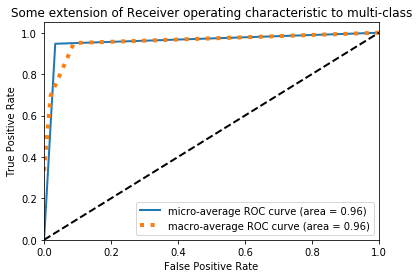

In [6]:
# Plot all multi-classification ROC curves.
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["micro"]),
         linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],label='macro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["macro"]),
        linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--',lw = 2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend()
plt.show()

### Because the number of data is small, the micro-average ROC and macro-average ROC are similar.

---

In [7]:
from sklearn.model_selection import learning_curve,validation_curve,ShuffleSplit,KFold
 
#Load the iris data.
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [8]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.05, 1.0,20),theshold=0.98):
    '''
    This is a function to draw a model learning curve.
    -----------------------------------------------------------
    parameter:
      estiamtor:Machine learning algorithm.
      title:The name of painting.                     ->str
      X:All of your data of the datasets.             ->array
      y:All of your target of the datasets.           ->array
      ylim:The limitation of your curve's y.          ->list
      cv:You want the numbers of the cross-validation.->integer
      n_jobs:The number of jobs to use for the computation. If -1 all CPUs are used.
             This will only provide speedup for n_targets > 1 and sufficient large problems.
      theshold:You want the level that tha model can reach.
      -----------------------------------------------------------
    Return:
      plt
    '''
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    b = [theshold]*300
    plt.plot(b)
    plt.legend(loc="best")
    return plt

## Learning Curve

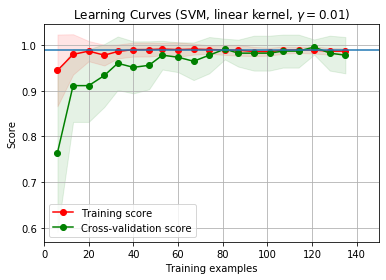

In [9]:
# This is the learning curve of SVM with ShuffleSplit.
title = r"Learning Curves (SVM, linear kernel, $\gamma=0.01$)"
cv = ShuffleSplit(n_splits=15, test_size=0.1, random_state=0)
estimator = svm.SVC(kernel='linear',gamma=0.01)
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=1,theshold=0.99)
plt.xlim([0,150])
plt.show()

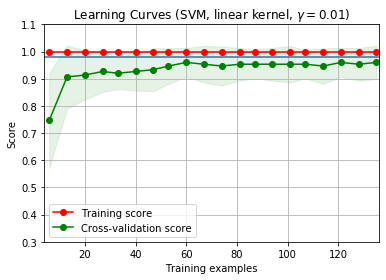

In [10]:
# This is the learning curve of DecisionTree with ShuffleSplit.
cv = ShuffleSplit(n_splits=10,test_size=0.1,random_state=0)
estimator = tree.DecisionTreeClassifier()
plot_learning_curve(estimator, title, X, y, [0.3, 1.1], cv=cv, n_jobs=1)
plt.xlim([4,136])
plt.show()

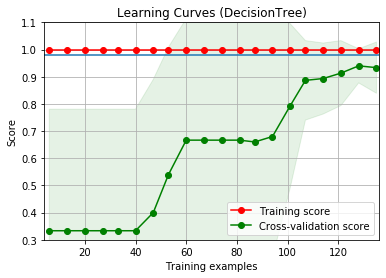

In [11]:
#This is the learning curve of DecisionTree with KFold.
title = r"Learning Curves (DecisionTree)"
cv = KFold(n_splits=10).split(X,y)
estimator = tree.DecisionTreeClassifier()
plot_learning_curve(estimator, title, X, y, [0.3, 1.1], cv=cv, n_jobs=1)
plt.xlim([4,136])
plt.show()

### The picture is the learning curve of DecisionTree on iris database.   
During this process，I use the 10-fold cross validation class **ShuffleSplit** and **KFold**. We can find the training score and cross-validation score are converging to the blue line.     
The blue line can be seen as what we want 

--------

In [12]:
def plot_validation_curve(estimator, title, X, y,param_name,param_range=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                          cv=10,n_jobs=1):
    '''
    This is a function to draw a model validation curve.
    -----------------------------------------------------------
    parameter:
      estiamtor:Machine learning algorithm.
      title:The name of painting.                     ->str
      X:All of your data of the datasets.             ->array
      y:All of your target of the datasets.           ->array
      param_name:The name of parameter you want to optimize.(It must conform the machine learning model.)
      param_range:The range of parameter you want to optimize.->list
      cv:You want the numbers of the cross-validation.        ->integer
      n_jobs:The number of jobs to use for the computation. If -1 all CPUs are used.
             This will only provide speedup for n_targets > 1 and sufficient large problems.
      -----------------------------------------------------------
    Return:
      plt
    '''
    plt.figure()
    plt.title(title)
    train_scores, test_scores = validation_curve(
                estimator=estimator, X=X, y=y, param_name=param_name, param_range=param_range,cv=cv)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1) 
    plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')
    plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')
    plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')
    plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')
    plt.grid()
    plt.legend(loc='best')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.tight_layout()
    return plt

## Validation Curve

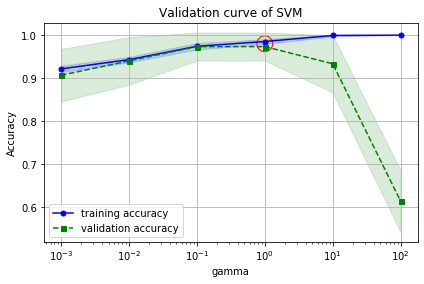

In [13]:
# This is the validation curve of SVM.
title = r"Validation curve of SVM"
plot_validation_curve(svm.SVC(),title,X, y, "gamma", cv=10)
# Draw a circle to get the best parameter.
plt.scatter(1, 0.98, color='', marker='o', edgecolors='r', s=250)
plt.xscale('log')
plt.show()

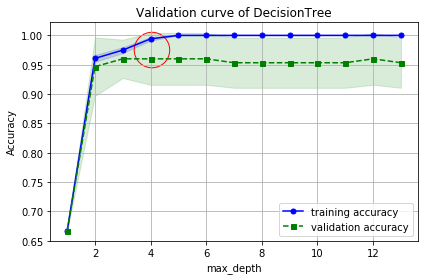

In [14]:
# This is the validation curve of DecisionTree.
title = r"Validation curve of DecisionTree"
plot_validation_curve(tree.DecisionTreeClassifier(),title,X, y, "max_depth",[1,2,3,4,5,6,7,8,9,10,11,12,13],cv=10)
plt.scatter(4.05, 0.975,color='', marker='o', edgecolors='r', s=1260)
plt.show()

### We can find the best gamma is 10<sup>0</sup>. I have marked it with a red circle. And the best max_depth is 4.

In [15]:
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler

iris = datasets.load_iris()
X = iris.data
y = iris.target

sc = StandardScaler()
sc.fit(X)
x_std = sc.transform(X)

x_train_std, x_test_std, y_train, y_test = train_test_split(X,y, test_size=0.4, random_state=1,stratify=y)


gs = GridSearchCV(estimator=tree.DecisionTreeClassifier(random_state=10),
                 param_grid=[{'max_depth':[1,2,3,4,5]}],scoring='accuracy',cv=5)
scores = cross_val_score(gs,x_std,y,scoring='accuracy',cv=5)
print(scores,np.mean(scores),np.var(scores))

[0.96666667 0.96666667 0.93333333 1.         1.        ] 0.9733333333333334 0.000622222222222222


### From the nested cross validation, we can know when the depth is 4(the mutation), the accuracy is 100%. We can find the best max_depth is 4.